HW3 Problem 1  
- File Names and Directory Structure: Logfile and image directory is created in the current working directory. Check here: [filestructure](#filestructure)  
- Check for Hypter Parameters here: [hyperparameters](#hyperparameters)
    -   Specifically set the **num_components** to 1 if you want to generate the graph from the beginning, and
    -   Select the **USE_FASHION_MNIST** Flag for selecting between MNIST and FASHION_MNIST
    -   goal specifies whetehr we want to achieve 95% or 99% accuracy
- Problem:   
**PCA for MNIST and FMNIST:** In lecture we considered least-squares classification
applied to MNIST and FMNIST. We also considered PCA for reducing the dimensionality
of MNIST/FMNIST. In this problem, you will combine these two concepts. Specifically, you
will perform PCA on these datasets and then use a least-squares classifier on the reduced
dimension data. Specifically, perform the following on both MNIST and FMNIST:  
(a) Find the minimum number of dimensions to keep so that the accuracy on the training
data, relative to that obtained using the original data, degrades by no more than 1
percent. Report this minimum value of dimension, the accuracy on the training data,
the accuracy on the test data, and the percent of energy retained using this minimum
dimension.  
(b) Repeat the previous part, but find the minimum dimensionality that results in a loss in
accuracy of no more than 5%.  
(c) Show a plot of the training and test accuracy vs. Dimension of the input for the
MNIST/FMNIST dataset. 

### import libraries

In [374]:
import numpy as np 
import matplotlib.pyplot as plt
from torchvision import datasets
import random                       # to generate the seed number randomly
import copy

In [375]:
# for bookkeeping
import csv
from datetime import datetime
import getpass                      # to get the username
import os                           # to move around files
import sys                          # to abort the execution

#### filestructure
In order to improve from HW2, where the feedback was to improve the file names used, this time, the code checks if its my system or any other system, and for system other than belonging to the creator, it eases the file names to a folder named USCID_2398388668

In [376]:
username = getpass.getuser()        # Get the current username
img_dir_name = "img"
log_fname = "hw3_problem1.csv"

if username == "jasne":
    current_dir = os.getcwd()
    if os.path.basename(current_dir) == "assignment3":          # checks that it is the correct execution path
        if not os.path.exists(os.path.join(current_dir, img_dir_name)):
            os.makedirs(os.path.join(current_dir, img_dir_name))
        img_dir_abs_path = os.path.join(current_dir,img_dir_name)
        log_fname_abs_path = os.path.join(current_dir,log_fname)
    else:   
        print(f'Not in the correct directory')
        sys.exit(1)
else:
    current_dir = os.getcwd()
    logfname = "hw3_problem1_2398388668.csv"
    log_fname_abs_path = os.path.join(current_dir,log_fname)
    if not os.path.exists(os.path.join(current_dir, img_dir_name)):
        os.makedirs(os.path.join(current_dir, img_dir_name))
    img_dir_abs_path = os.path.join(current_dir,img_dir_name)

current_time = datetime.now()
time_string = current_time.strftime("%Y-%m-%d %H:%M:%S")
fn_time_string = time_string.replace(':', '_').replace('-', '_')

### hyperparameters

In [377]:
USE_FASHION_MNIST = True                   # if false, runs MNIST
LOADMNISTDATA_QUIET = True                 # if false, prints the info. in load_MNIST_data function
PCENERGY_QUIET = True                         # if false, plots the PC energy
MULTICLASSHIST_QUIET = True                # if false, plots the multi class histograms
mnist_peak_accuracy = 85.7733333333333
fashionmnist_peak_train_accuracy = 83.11333333
num_components = 0                         # this term defines the numer of components for decoded data W, W's shape shall be Pxnum_components
goal = 0.95

### helper functions

function: load the data from the database

In [378]:
"""returns: x_train.shape  = (P x PixelHeight x PixelWidth)     e.g. (60000 x 28 x 28)
            y_train.shape  = (P,) type = numpy.ndarray          e.g. (60000,)
            x_test.shape   = (P x PixelHeight x PixelWidth)     e.g. (10000,28, 28)
            y_test.shape   = (P,) type = numpy.ndarray          e.g. (10000,)
"""
def load_MNIST_data(data_path, fashion=False, quiet=False):
    if not fashion:
        train_set = datasets.MNIST(data_path, download=True, train=True)
        test_set = datasets.MNIST(data_path, download=True, train=False)
    else:
        train_set = datasets.FashionMNIST(data_path, download=True, train=True)
        test_set = datasets.FashionMNIST(data_path, download=True, train=False)      
    x_train = train_set.data.numpy()
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy()
    y_test = test_set.targets.numpy()
    
    N_train, H, W = x_train.shape
    N_test, H, W = x_test.shape

    if not quiet:
        print(f'The data are {H} x {W} grayscale images.')
        print(f'N_train = {N_train}')
        print(f'N_test = {N_test}')
    for i in set(y_train):
        N_i_train = np.sum(y_train==i)
        N_i_test = np.sum(y_test==i)
        if not quiet:
            print(f'Class {i}: has {N_i_train} train images ({100 * N_i_train / N_train : .2f} %), {N_i_test} test images ({100 * N_i_test/ N_test : .2f} %) ')
    return x_train, y_train, x_test, y_test

Following functions are used to get augment the data (add the 1s) and then flatten.  Then, we create the target matrix ${\bf Y}$ which is a $(P \times C)$ matrix.  The $p^{th}$ row of this matrix has the correct class labels for the $p^{th}$ data point.  We adopt the convention that this is $-1$ at all columns (classes) except the correct class, for which it is $+1$.

In [379]:
"""
expects input matrix X of the shape P x H x W
returns P x (1+D) matrix
"""
def flatten_and_augment(x):
    P, H, W = x.shape
    D = H * W
    x_aug = np.ones((P, D + 1))
    x_aug[:, 1:] = x.reshape((P, D))
    return x_aug
"""
returns matrix of shape P x C
"""
def create_target_matrix(labels):
    label_vals = list(set(labels))
    C = len(label_vals)                     # C <- No. of classes
    P = len(labels)                         # P <- No. of Data Points
    y = -1 * np.ones((P, C)) 
    for n in range(P):
        y[n][labels[n]] = +1
    return y

In [380]:
def plot_multiclass_histograms(X_aug, W, y, fname, norm_W=False, scale=1, class_names=None):
    """
    Keith Chugg, USC, 2023.

    X_aug: shape: (N, D + 1).  Augmented data matrix
    W: shape: (D + 1, C).  The matrix of augmented weight-vectors.  W.T[m] is the weight vector for class m
    y: length N array with int values with correct classes.  Classes are indexed from 0 up.
    fname: a pdf of the histgrams will be saved to filename fname
    norm_W: boolean.  If True, the w-vectors for each class are normalized.
    scale: use scale < 1 to make the figure smaller, >1 to make it bigger
    class_names: pass a list of text, descriptive names for the classes.  

    This function takes in the weight vectors for a linear classifier and applied the "maximum value methd" -- i.e., 
    it computes the argmax_m g_m(x), where g_m(x) = w_m^T x to find the decision. For each class, it plots the historgrams 
    of  g_m(x) when class c is true.  This gives insights into which classes are most easily confused -- i.e., similar to a 
    confusion matrix, but more information.  

    Returns: the overall misclassification error percentage
    """
    if norm_W:
       W = W / np.linalg.norm(W, axis=0)
    y_soft = X_aug @ W
    N, C = y_soft.shape
    y_hard = np.argmax(y_soft, axis=1)
    error_percent = 100 * np.sum(y != y_hard) / len(y) 

    if not MULTICLASSHIST_QUIET:
        fig, ax = plt.subplots(C, sharex=True, figsize=(12 * scale, 4 * C * scale))
    y_soft_cs = []
    conditional_error_rate = np.zeros(C)
    if class_names is None:
        class_names = [f'Class {i}' for i in range(C)]
    for c_true in range(C):
        y_soft_cs.append(X_aug[y == c_true] @ W)
        #y_soft_cs.append(X_aug[y_train == c_true] @ W)
        y_hard_c = np.argmax(y_soft_cs[c_true], axis=1)
        conditional_error_rate[c_true] = 100 * np.sum(y_hard_c != c_true) / len(y_hard_c)

    if not MULTICLASSHIST_QUIET:
        for c_true in range(C):
            peak = -100
            for c in range(C):
                hc = ax[c_true].hist(y_soft_cs[c_true].T[c], bins = 100, alpha=0.4, label=class_names[c])
                peak = np.maximum(np.max(hc[0]), peak)
                ax[c_true].legend()
                ax[c_true].grid(':')
            ax[c_true].text(0, 0.9 * peak, f'True: {class_names[c_true]}\nConditional Error Rate = {conditional_error_rate[c_true] : 0.2f}%')
        if norm_W:
            ax[C-1].set_xlabel(r'normalized discriminant function $g_m(x) / || {\bf w} ||$')
        else:
            ax[C-1].set_xlabel(r'discriminant function $g_m(x)$')
        plt.savefig(fname, bbox_inches='tight',)
    return error_percent

In [381]:
'''
A function for computing the principal components of an input data matrix.  Both
principal components and variance parameters (eigenvectors and eigenvalues of XX^T)
are returned
'''
def compute_pcs(X,lam):
    # create the correlation matrix
    P = float(X.shape[1])
    Cov = 1/P*np.dot(X,X.T) + lam*np.eye(X.shape[0])

    # use numpy function to compute eigenvalues / vectors of correlation matrix
    # np.linalg.eigh returns orthonomal matrix, whereas np.linalg.eig returns eigen vectors that may not be orthonormal
    D,V = np.linalg.eig(Cov)
    return D,V

In [382]:
'''
A function for producing the full PCA transformation on an input dataset X
X.shape = (N x P) 
K <- num_components
returns: encoded weights (K x P), eigen values and eigen vectors
'''
def pca_transform_data(X,**kwargs):
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']
    
    # compute principal components
    D,V = compute_pcs(X,lam)
    small_to_big = np.argsort(D)
    big_to_small = small_to_big[::-1]
    D = D[big_to_small]
    D = D[:num_components]
    V = V[:,big_to_small]
    V = V[:,:num_components]

    #V = V[:,-num_components:]
    #D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W, D,V

## program begins here

load from the database

In [383]:
if USE_FASHION_MNIST:
    tag_name = 'FashionMNIST'
    database = True
    label_names = ["top", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]
else:
    tag_name = 'MNIST'
    database = False

x_train, y_train, x_test, y_test = load_MNIST_data('./data/', fashion=database, quiet=LOADMNISTDATA_QUIET)

if not USE_FASHION_MNIST:
    label_names = [f'{i}' for i in set(y_test)]

# normalized
x_train_float = x_train.astype("float32") 
x_train_normalized = x_train_float/255.0

x_test_float = x_test.astype("float32")
x_test_normalized = x_test_float/255.0

x_train_reshaped = x_train_normalized.reshape(len(x_train_normalized),-1)       # i/p: P x N
x_test_reshaped = x_test_normalized.reshape(len(x_test_normalized),-1)          # i/p: P x N

initializations

In [384]:
if USE_FASHION_MNIST:
    peak_accuracy = fashionmnist_peak_train_accuracy
else:
    peak_accuracy = mnist_peak_accuracy
target_accuracy = goal * peak_accuracy
accuracy_percent = 0
train_accuracy_percent = 0
num_components_history = []
train_accuracy_history = []
test_accuracy_history = []

Loop over till accuracy surpasses 90% of target accuracy
-   Calculate PC by calling pca_transformed_data function, it returns eigen vectors for num_componentys along with transofrmed data and eigen values. Eigen vectors and energies returned in descending order i.e. most important to least important
-   Calculate the energies from eigen values
-   Alternatively, it is a Maximal Value Method (MVM) where the weight vectors are optimized with the MSE criterion and the multiclass targets.  We will use the `np.linalg.lstsq()` routine to solve the MSE regression problem.  This is the pseudo-inverse appoach, not gradient descent!
The `np.linalg.lstsq()` routine can handle passing the matrix targets ${\bf Y}$ instead of vector targets ${\bf y}_c$ -- i.e., the $c$-th column of ${\bf Y}$.  One call with a matrix of targets is equivalent to $C$ calls with the associated vectors targets $\{{\bf y}_c\}_{c=1}^C$.
-   Calcuating the accuracy for training and testing data

In [385]:
while train_accuracy_percent < target_accuracy and num_components < 784:
    num_components += 1
    num_components_history.append(num_components)
    """
    PC calculation
    """
    print(f'number of input dimensions are: {num_components}')
    encoded_x_train, e_vals,V = pca_transform_data(x_train_reshaped.T, num_components = num_components)          # i/p: N x P
    # Shape of V is N x K, thus V.T shape is K x N
    encoded_x_test = np.dot(V.T,x_test_reshaped.T)
    print(f'transformed training data points dimensions: {encoded_x_train.shape[0]}')
    print(f'transformed testing data points dimensions: {encoded_x_test.shape[0]}')
    pcs = V    
    print(f'lambdas: {e_vals[:10]}')

    """
    plotting eigen vectors in descending order : first 47
    """
    if not PCENERGY_QUIET:
        plt.figure()
        plt.stem(10 * np.log10(e_vals[:47]))
        plt.grid(';')
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('eigen value in dB')

        plt.figure()
        plt.plot(10 * np.log10(e_vals))
        plt.grid(';')
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('eigen value in dB')

    """
    energy calculcation
    """
    H_W = len(e_vals)
    percent_energy = np.zeros(H_W)
    for k in range(H_W):
        percent_energy[k] = np.sum(e_vals[:k])
    percent_energy = 100 * percent_energy / np.sum(e_vals)

    print(f'percentage energy shape: {percent_energy.shape}')
    """
    plotting energies on the graph
    """
    if not PCENERGY_QUIET:
        plt.figure()
        plt.plot(np.arange(H_W), percent_energy, color='b', label='energy')
        plt.plot(np.arange(H_W), 100 - percent_energy, color='r', label='error energy')
        plt.axhline(95, color='b', linestyle='--', label='95%')
        plt.axhline(5, color='r', linestyle='--', label='5%')
        plt.grid(';')
        plt.legend()
        plt.xlim([0,200])
        plt.xlabel('eigen value index (max to min)')
        plt.ylabel('Percent Energy')
        plt.show()

    """
    modelling the data for input to lstsq
    """
    encoded_x_train_aug = np.ones((encoded_x_train.shape[1], encoded_x_train.shape[0] + 1))
    encoded_x_train_aug[:, 1:] = encoded_x_train.T
    encoded_x_test_aug = np.ones((encoded_x_test.shape[1], encoded_x_test.shape[0] + 1))
    encoded_x_test_aug[:, 1:] = encoded_x_test.T

    Y = create_target_matrix(y_train)

    """
    Multi-Class Classication Decision Boundary Calculation
    lstsq expects encoded_xtrain_aug of the shape P x (1+D) and Y of the shape P x C
    here W_hat is the multi-class classifcation decision boundary w
    """
    W_hat = np.linalg.lstsq(encoded_x_train_aug, Y, rcond=None)[0]

    """
    plot_multiclass_histograms expects 
    data_pts.shape      = (P x (1+D)) 
    W_hat.shape         = ((1+D) x C)
    labels_pts.shape    = (P,)

    """
    train_error_rate = plot_multiclass_histograms(encoded_x_train_aug, W_hat, y_train, f'img/hist_{tag_name}.pdf', scale=1, class_names=label_names)
    print(f'\nOverall Training Misclassification Rate: {train_error_rate : 0.2f}%')
    train_accuracy_percent = 100 - train_error_rate
    train_accuracy_history.append(train_accuracy_percent)
    test_error_rate = plot_multiclass_histograms(encoded_x_test_aug, W_hat, y_test, f'img/hist_{tag_name}.pdf', scale=1, class_names=label_names)
    print(f'\nOverall Testing Misclassification Rate: {test_error_rate : 0.2f}%')
    test_accuracy_percent = 100 - test_error_rate
    test_accuracy_history.append(test_accuracy_percent)

    """log all required outputs"""
    if not os.path.exists(log_fname_abs_path):    
        with open(log_fname_abs_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["time","No. of dimensions","training accuracy %", "testing accuracy %", "Energy %", "Dataset"])
            writer.writerow([fn_time_string, num_components, train_accuracy_percent, test_accuracy_percent, percent_energy[num_components-1],tag_name])
    else:
        with open(log_fname_abs_path, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([fn_time_string, num_components, train_accuracy_percent, test_accuracy_percent, percent_energy[num_components-1],tag_name])

number of input dimensions are: 1
transformed training data points dimensions: 1
transformed testing data points dimensions: 1
lambdas: [110.2839267]
percentage energy shape: (1,)

Overall Training Misclassification Rate:  81.71%

Overall Testing Misclassification Rate:  81.61%
number of input dimensions are: 2
transformed training data points dimensions: 2
transformed testing data points dimensions: 2
lambdas: [110.2839267   13.25802906]
percentage energy shape: (2,)

Overall Training Misclassification Rate:  61.76%

Overall Testing Misclassification Rate:  61.52%
number of input dimensions are: 3
transformed training data points dimensions: 3
transformed testing data points dimensions: 3
lambdas: [110.2839267   13.25802906   5.60658168]
percentage energy shape: (3,)

Overall Training Misclassification Rate:  57.14%

Overall Testing Misclassification Rate:  56.72%
number of input dimensions are: 4
transformed training data points dimensions: 4
transformed testing data points dimension

plot training accuracy vs testing accuracy graph

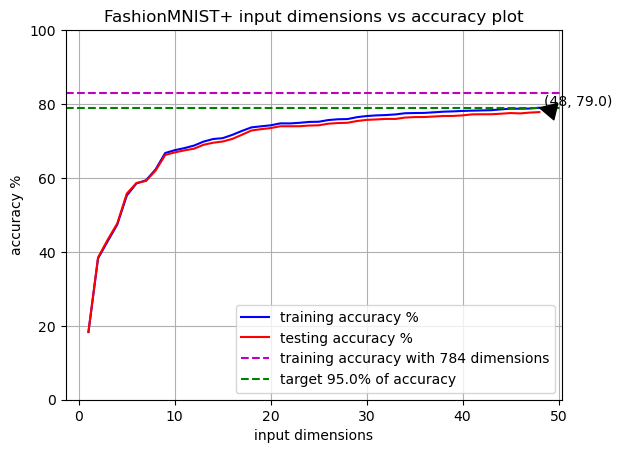

In [386]:
plt.figure()
plt.plot(num_components_history, train_accuracy_history, color='b', label='training accuracy %')
plt.plot(num_components_history, test_accuracy_history, color='r', label='testing accuracy %')
plt.grid(';')
plt.xlabel('input dimensions')
plt.ylabel('accuracy %')
plt.axhline(peak_accuracy, color='m', linestyle='--', label='training accuracy with 784 dimensions')
plt.axhline(target_accuracy, color='g', linestyle='--', label=f'target {100*goal}% of accuracy')
last_point = (num_components_history[-1], train_accuracy_history[-1])
# Annotate the last point
plt.annotate(f'({num_components_history[-1]}, {round(train_accuracy_history[-1],2)})', xy=last_point, xytext=(last_point[0]+0.5, last_point[1]+0.5), arrowprops=dict(facecolor='black', shrink=0.05))
plt.ylim([0,100])
plt.title(f'{tag_name}+ input dimensions vs accuracy plot')
plt.legend()

# save the graph
fig_fname = tag_name + fn_time_string + "_accuracy_vs_dim.jpg" 
fig_fname_abs_path = os.path.join(img_dir_abs_path,fig_fname)
plt.savefig(fig_fname_abs_path,format='jpg',bbox_inches='tight')
plt.show()